In [1]:
# Look for *.tif files in all subfolders.
from os import walk
from os.path import join, split
import fnmatch
folderName = '/home/jiongyi/Documents/dna_damage/immunofluorescence/wildtype/2_gamma/WT RPA32 2g 1hr postIR'
tifFilePaths = []
searchString = '*ome.tif'
for (dirPath, dirNames, fileNames) in walk(folderName):
    for fileName in fileNames:
        if fnmatch.fnmatch(fileName, searchString):
            tifFilePaths.append(join(dirPath, fileName))

In [2]:
# Define main function.
from numpy import array, zeros, std, where, median, mean, sqrt, stack, argmax, arange
from skimage import img_as_float, img_as_uint
from skimage.io import imread, imsave
from skimage.exposure import equalize_adapthist
from skimage.filters import sobel, gaussian, threshold_otsu, threshold_local
from skimage.morphology import remove_small_objects, disk
from skimage.measure import regionprops, label
from skimage.segmentation import find_boundaries
import csv

# Define constants.
px2um = 0.10185185185**2
def dog_filter(rawImg, objDiameter):
    sigma1 = objDiameter / (sqrt(2) + 1)
    sigma2 = objDiameter * sqrt(2)
    gauss1Img = gaussian(rawImg, sigma1)
    gauss2Img = gaussian(rawImg, sigma2)
    dogImg = gauss1Img - gauss2Img
    dogImg -= min(dogImg.flatten())
    return dogImg

def extended_depth_field(stack):
    noStacks, noRows, noCols = stack.shape
    gaussStack = zeros((noStacks, noRows, noCols))
    sobelStack = zeros((noStacks, noRows, noCols))
    for i in range(noStacks):
        sobelStack[i, :, :] = sobel(stack[i, :, :])
    idxMaxEdgeImg = argmax(sobelStack, axis = 0)
    stack = stack.reshape((noStacks, -1))
    stack = stack.transpose()
    extDepthImg = stack[arange(len(stack)), idxMaxEdgeImg.ravel()]
    extDepthImg = extDepthImg.reshape((noRows, noCols))
    return gaussian(extDepthImg)

def quantify_colocalization(tifFilePath, saveImages = False):
    # Load stack.
    zLambdaStack = img_as_float(imread(tifFilePath))
    # Restack.
    noChannels, noSlices, noRows, noColumns = zLambdaStack.shape
    lambda1Stack = zLambdaStack[0, :, :]
    lambda2Stack = zLambdaStack[1, :, :]
    lambda3Stack = zLambdaStack[2, :, :]
    # Find focused image.
    lambda1Img = extended_depth_field(lambda1Stack)
    lambda2Img = extended_depth_field(lambda2Stack)
    lambda3Img = extended_depth_field(lambda3Stack)
    # Enhance contrast.
    eqLambda1Img = equalize_adapthist(lambda1Img)
    eqLambda2Img = equalize_adapthist(lambda2Img)
    eqLambda3Img = equalize_adapthist(lambda3Img)
    
    # Apply difference-of-Gaussians filter.
    dogLambda1Img = dog_filter(eqLambda1Img, 3)
    dogLambda2Img = dog_filter(eqLambda2Img, 3)

    gaussLambda3Img = gaussian(eqLambda3Img, 1)
    
    # Segment.
    bwLambda3Img = gaussLambda3Img > threshold_otsu(gaussLambda3Img)
    bwLambda1Img = dogLambda1Img > threshold_local(dogLambda1Img, block_size = 31, offset = -3 * std(dogLambda1Img.flatten()))
    bwLambda2Img = dogLambda2Img > threshold_local(dogLambda2Img, block_size = 31, offset = -3 * std(dogLambda2Img.flatten()))
        
    # Remove small objects.
    bwLambda1Img = remove_small_objects(bwLambda1Img, 9)
    bwLambda2Img = remove_small_objects(bwLambda2Img, 9)
    bwLambda3Img = remove_small_objects(bwLambda3Img, 97)
    
    # Ignore objects outside nuclear regions.
    bwLambda1Img *= bwLambda3Img
    bwLambda2Img *= bwLambda3Img
    
    # Extract region properies and write to csv.
    lambda1MeanBckgrdInt = mean(lambda1Img[~bwLambda1Img * bwLambda3Img].flatten())
    lambda2MeanBckgrdInt = mean(lambda2Img[~bwLambda2Img * bwLambda3Img].flatten())
    lambda3MeanBckgrdInt = mean(lambda3Img[~bwLambda3Img].flatten())
    lambda3LabeledImg = label(bwLambda3Img)
    lambda3RegPropsList = regionprops(lambda3LabeledImg, lambda3Img - lambda3MeanBckgrdInt)
    bwLambda12Img = remove_small_objects(bwLambda1Img * bwLambda2Img, 9)

    # Extract properties of nuclear regions.
    noLambda3Objs = len(lambda3RegPropsList)
    with open(tifFilePath[:-4] + '_lambda3_quant.csv', 'w') as csvFile:
        fieldNames = ['file_name', 'nuclear_region', 'mean_intensity', 'region_size', 
                      'no_lambda1_regions', 'no_lambda2_regions', 'lambda1_flux', 'lambda2_flux', 'no_overlap_regions']
        writer = csv.DictWriter(csvFile, fieldnames = fieldNames)
        writer.writeheader()
        rootPath, filePath = split(tifFilePath)
        for i in range(noLambda3Objs):
            currentLabel = lambda3RegPropsList[i].label
            lambda1RegPropsList = regionprops(label(bwLambda1Img * (lambda3LabeledImg == currentLabel)), lambda1Img / lambda1MeanBckgrdInt)
            lambda2RegPropsList = regionprops(label(bwLambda2Img * (lambda3LabeledImg == currentLabel)), lambda2Img / lambda2MeanBckgrdInt)
            lambda12RegPropsList = regionprops(label(bwLambda12Img * (lambda3LabeledImg == currentLabel)))
            noLambda1Objs = len(lambda1RegPropsList)
            noLambda2Objs = len(lambda2RegPropsList)
            noOverlapObjs = len(lambda12RegPropsList)
            lambda1RegAreaArr = array([x.area for x in lambda1RegPropsList]) * px2um
            lambda2RegAreaArr = array([x.area for x in lambda2RegPropsList]) * px2um
            lambda1MeanIntArr = array([x.mean_intensity for x in lambda1RegPropsList])
            lambda2MeanIntArr = array([x.mean_intensity for x in lambda2RegPropsList])
            lambda1Flux = sum(lambda1RegAreaArr * lambda1MeanIntArr) / (lambda3RegPropsList[i].area * px2um)
            lambda2Flux = sum(lambda2RegAreaArr * lambda2MeanIntArr) / (lambda3RegPropsList[i].area * px2um)
            writer.writerow({'file_name': filePath, 'nuclear_region': str(i), 'mean_intensity': str(lambda3RegPropsList[i].mean_intensity),
                             'region_size': str(lambda3RegPropsList[i].area * px2um), 'no_lambda1_regions': str(noLambda1Objs), 'no_lambda2_regions': str(noLambda2Objs), 
                             'lambda1_flux': str(lambda1Flux), 'lambda2_flux': str(lambda2Flux), 'no_overlap_regions': noOverlapObjs})
            
    # Save images.
    if saveImages == True:
        # Boundaries.
        boundLambda1Img = find_boundaries(bwLambda1Img * bwLambda3Img)
        boundLambda2Img = find_boundaries(bwLambda2Img * bwLambda3Img)
        boundLambda3Img = find_boundaries(bwLambda3Img)

        # Create image overlays.
        eqLambda1Img /= max(eqLambda1Img.flatten())
        eqLambda2Img /= max(eqLambda2Img.flatten())
        eqLambda3Img /= max(eqLambda3Img.flatten())
        overLambda1Img = stack((boundLambda1Img, eqLambda1Img, eqLambda1Img), axis = -1)
        overLambda2Img = stack((eqLambda2Img, boundLambda2Img, eqLambda2Img), axis = -1)
        overLambda3Img = stack((eqLambda3Img, eqLambda3Img, boundLambda3Img), axis = -1)
        threeLambdaImg = stack((eqLambda1Img, eqLambda2Img, eqLambda3Img), axis = -1)
        imsave(tifFilePath[:-4] + '_lambda1_overlay.tif', img_as_uint(overLambda1Img))
        imsave(tifFilePath[:-4] + '_lambda2_overlay.tif', img_as_uint(overLambda2Img))
        imsave(tifFilePath[:-4] + '_lambda3_overlay.tif', img_as_uint(overLambda3Img))
        imsave(tifFilePath[:-4] + '_three_channel.tif', img_as_uint(threeLambdaImg))

In [3]:
# Run batch quantification.
for i in range(len(tifFilePaths)):
    try:
        quantify_colocalization(tifFilePaths[i], saveImages = True)
    except:
        print('Failed to analyze ' + tifFilePaths[i])
        continue

/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/jiongyi/Documents/dna_damage/immunofluorescence/wildtype/2_gamma/WT RPA32 2g 1hr postIR/wt rpa32 2g 1hr_14/wt rpa32 2g 1hr_14_MMStack.ome_lambda1_overlay.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/jiongyi/Documents/dna_damage/immunofluorescence/wildtype/2_gamma/WT RPA32 2g 1hr postIR/wt rpa32 2g 1hr_14/wt rpa32 2g 1hr_14_MMStack.ome_lambda2_overlay.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/jiongyi/Documents/dna_damage/immunofluorescence/wildtype/2_gamma/WT RPA

In [4]:
# Compile all csv files.
csvFilePaths = []
allCsvDict = {'file_name': [], 'nuclear_region': [], 'mean_intensity': [], 'region_size': [], 
              'no_lambda1_regions': [], 'no_lambda2_regions': [], 'lambda1_flux': [], 
              'lambda2_flux': [], 'no_overlap_regions': []}
searchString = '*_lambda3_quant.csv'
for (dirPath, dirNames, fileNames) in walk(folderName):
    for fileName in fileNames:
        if fnmatch.fnmatch(fileName, searchString):
            csvFilePaths.append(join(dirPath, fileName))
with open(folderName + '/compiled_lambda3_quant.csv', 'w') as csvWriteFile:
    fieldNames = ['file_name', 'nuclear_region', 'mean_intensity', 'region_size', 'no_lambda1_regions', 'no_lambda2_regions', 'lambda1_flux', 'lambda2_flux', 'no_overlap_regions']
    writer = csv.DictWriter(csvWriteFile, fieldnames = fieldNames)
    writer.writeheader()
    for i in range(len(csvFilePaths)):
        with open(csvFilePaths[i], 'r') as csvReadFile:
            reader = csv.DictReader(csvReadFile)
            for row in reader:
                writer.writerow(row)
                for key in row.keys():
                    try:
                        allCsvDict[key].append(float(row[key]))
                    except:
                        allCsvDict[key].append(row[key])

/home/jiongyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/jiongyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


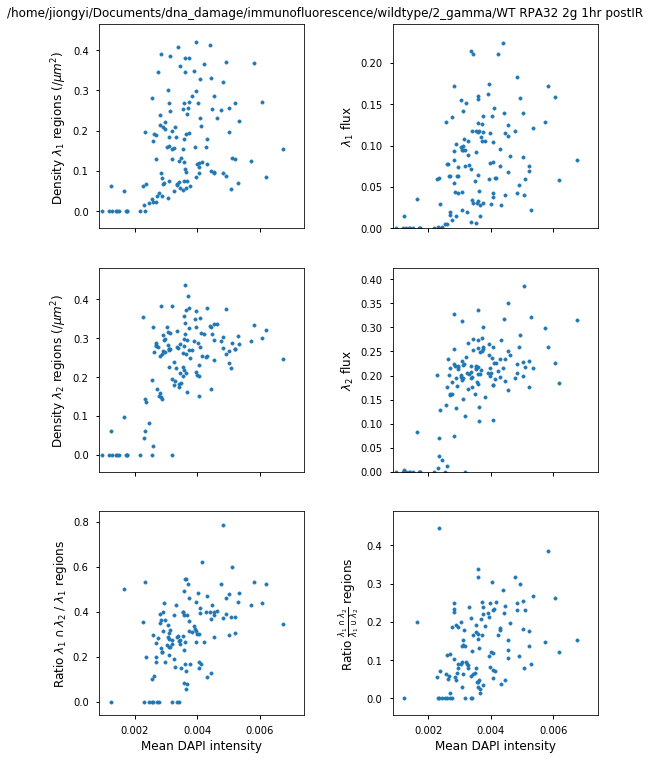

In [5]:
# Plot quantification.
from numpy import array, isnan, min, percentile
from matplotlib.pyplot import subplots, scatter, xlim, ylim, xlabel, ylabel, title, savefig, suptitle, tight_layout
from matplotlib import style

# Filter outlier nuclear regions by size.
lambda3AreaArr = array(allCsvDict['region_size'])
areaIntervalArr = percentile(lambda3AreaArr, [2.5, 97.5])
isAreaOKArr = (lambda3AreaArr >= areaIntervalArr[0]) * (lambda3AreaArr <= areaIntervalArr[1])
lambda3AreaArr = lambda3AreaArr[isAreaOKArr]
meanIntDAPIArr = array(allCsvDict['mean_intensity'])[isAreaOKArr]
noLambda1RegArr = array(allCsvDict['no_lambda1_regions'])[isAreaOKArr]
noLambda2RegArr = array(allCsvDict['no_lambda2_regions'])[isAreaOKArr]
lambda1FluxArr = array(allCsvDict['lambda1_flux'])[isAreaOKArr]
lambda2FluxArr = array(allCsvDict['lambda2_flux'])[isAreaOKArr]
noOverlapRegArr = array(allCsvDict['no_overlap_regions'])[isAreaOKArr]

style.use('seaborn-notebook')
figObj, axObj = subplots(ncols = 2, nrows = 3, sharex = 'all', squeeze = False)

figObj.suptitle(folderName)

dapiRangeList = [0.9 * min(meanIntDAPIArr), 1.1 * max(meanIntDAPIArr)]
axObj[0, 0].scatter(meanIntDAPIArr, noLambda1RegArr / lambda3AreaArr, marker= '.')
axObj[0, 0].set_xlim(dapiRangeList)
axObj[0, 0].set_ylabel(r'Density $\lambda_1$ regions (/$\mu m^2$) ', fontsize = 12)

axObj[0, 1].scatter(meanIntDAPIArr, lambda1FluxArr, marker= '.')
axObj[0, 1].set_ylim([0.9 * min(lambda1FluxArr), 1.1 * max(lambda1FluxArr)])
axObj[0, 1].set_ylabel(r'$\lambda_1$ flux', fontsize = 12)

axObj[1, 0].scatter(meanIntDAPIArr, noLambda2RegArr / lambda3AreaArr, marker='.')
axObj[1, 0].set_ylabel('Density $\lambda_2$ regions (/$\mu m^2$)', fontsize = 12)

axObj[1, 1].scatter(meanIntDAPIArr, lambda2FluxArr, marker='.')
axObj[1, 1].set_ylim([0.9 * min(lambda2FluxArr), 1.1 * max(lambda2FluxArr)])
axObj[1, 1].set_ylabel('$\lambda_2$ flux', fontsize = 12)

axObj[2, 0].scatter(meanIntDAPIArr, noOverlapRegArr / noLambda1RegArr, marker='.')
axObj[2, 0].set_xlabel('Mean DAPI intensity', fontsize = 12)
axObj[2, 0].set_ylabel(r'Ratio $\lambda_1 \cap \lambda_2$ / $\lambda_1$ regions', fontsize = 12)

axObj[2, 1].scatter(meanIntDAPIArr, noOverlapRegArr / (noLambda1RegArr + noLambda2RegArr - noOverlapRegArr), marker='.')
axObj[2, 1].set_xlabel('Mean DAPI intensity', fontsize = 12)
axObj[2, 1].set_ylabel(r'Ratio $\frac{\lambda_1 \cap \lambda_2}{\lambda_1 \cup \lambda_2}$ regions', fontsize = 12)

figObj.set_figheight(11)
figObj.set_figwidth(8.5)
tight_layout(pad = 3)
savefig(folderName + '/scatter_plots.png')

In [6]:
from scipy.stats import spearmanr
spearmanr(meanIntDAPIArr, lambda1FluxArr)

SpearmanrResult(correlation=0.46353699941614, pvalue=3.1656711166379725e-08)